# Homework 2024.9.18
扩展本节课学习的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等。

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import os
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

In [3]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            " Focus on clarity, structure, and quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations."
            "Notice: Your answer should always include the writing",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

writer = writer_prompt | ChatOllama(
    base_url="http://ollama.julia8848.com",
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=1.2,
)

In [4]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatOllama(
    base_url="http://ollama.julia8848.com",
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=0.2,
)

In [5]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [6]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [7]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

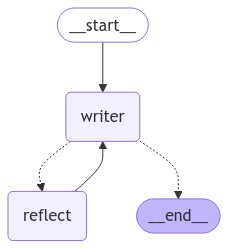

In [8]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [9]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [10]:
inputs = {
    "messages": [
        HumanMessage(content="写一段Python代码，生成8位密码，要求：强度高又好记")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- **生成好记但强度高的8位密码**
=====================================

以下是Python脚本，能够为您生成一串长度为8的好记但强度高的密码：
```python
import random
import string

def generate_password(length=8):
    """
    生成一串长度为length的好记但强度高的密码。
    
    :param length: 密码长度（默认为8）
    :return: 一串好的密码
    """
    # 使用大写字母、小写字母和数字构成的集合
    characters = string.ascii_letters + string.digits
    
    # 随机选择3个字符作为关键词，用于加强记忆性
    keywords = [random.choice(string.ascii_lowercase) for _ in range(3)]
    
    # 将关键词与随机选取的其它字符混合生成密码
    password = ''.join(keywords)
    for _ in range(length - 3):
        password += random.choice(characters)
    
    # 随机交换密码中两个位置上的字符，使密码更加难以猜测
    for i in range(10):
        a, b = random.sample(range(len(password)), 2)
        password = list(password)
        password[a], password[b] = password[b], password[a]
        password = ''.join(password)
    
    return password

print(generate_password())
```
这个脚本首先定义了一个`generate_password()`函数，该函数使用以下步骤生成密码：

1.  在集合中选择大写字母、小写字母和数字，用于构建密码。
2.  随机选取3个小写字母作为关键词，以增强密码的记忆性。
3.  将关键词与其他随机选定的字符混合起来生成密码，长度为`length`（默认值为8）。
4.  在密码中随机交换两个位置上的字符，来使得密码更加难以猜测。

该脚本提供了一个高强度且易于记忆的8位密码，每次运行都会生成不同的密码。


## Round 2

#### 评论反思:
- **代码评审**

您的脚本基本上实现了要求，但有几个地方可以改进以提高其可读性、结构和安全性。

### 1. 密码长度限制

在函数参数中，`length=8` 是一个固定值。如果用户希望生成不同长度的密码，需要手动修改该值。考虑添加一个选项或默认值，使用户可以自定义密码长度。

```python
def generate_password(length=8, min_length=3, max_length=16):
    # ...
```

### 2. 密码强度

虽然您的脚本使用了大写字母、小写字母和数字，但没有考虑到特殊字符（如 `!`, `@`, `$`, 等）的使用。考虑增加这些字符的可能性，进一步提高密码强度。

```python
characters = string.ascii_letters + string.digits + string.punctuation
```

### 3. 密码随机性

在交换两个位置上的字符时，您使用了 `random.sample()` 函数，这确实是一个好的选择。但是，如果您想进一步增加密码的随机性，可以考虑多次交换和其他混淆手段。

```python
for _ in range(10):
    a, b = random.sample(range(len(password)), 2)
    password = list(password)
    password[a], password[b] = password[b], password[a]
    password = ''.join(password)
```

### 4. 错误处理

如果用户输入了非整数或负数的长度值，脚本会抛出异常。考虑添加错误检查和处理逻辑，以确保函数可以正常工作。

```python
if not isinstance(length, int) or length < min_length or length > max_length:
    raise ValueError("Invalid password length")
```

### 5. 文档化

虽然您的脚本有一个基本的文档，但考虑添加更多详细信息，例如：

*   函数参数和返回值的说明
*   密码生成算法的描述
*   使用特殊字符或其他混淆手段的选项

```python
def generate_password(length=8, min_length=3, max_length=16):
    """
    生成一串长度为length的好记但强度高的密码。

    :param length: 密码长度（默认为8）
    :type length: int
    :param min_length: 最小密码长度（默认为3）
    :type min_length: int
    :param max_length: 最大密码长度（默认为16）
    :type max_length: int
    :return: 一串好的密码
    :rtype: str

    该函数使用以下步骤生成密码：
        1. 使用大写字母、小写字母和数字构成的集合。
        2. 随机选取3个小写字母作为关键词，用于加强记忆性。
        3. 将关键词与随机选取的其它字符混合生成密码。
        4. 在密码中随机交换两个位置上的字符，使密码更加难以猜测。

    可选参数：
        - 使用特殊字符或其他混淆手段（未实现）。
    """
```

### 6. 安全性

虽然您的脚本使用了 `random` 模块，但考虑使用更安全的随机数生成器，如 `secrets` 模块。

```python
import secrets
# ...
password = ''.join(secrets.choice(characters) for _ in range(length))
```

### 7. 性能

如果您需要生成大量密码，考虑优化脚本以提高性能。例如，可以使用多线程或并行处理来生成多个密码。

```python
import concurrent.futures
# ...
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(generate_password, length) for _ in range(10)]
    passwords = [future.result() for future in futures]
```

### 8. 测试

考虑添加测试用例来验证脚本的正确性和安全性。

```python
import unittest
# ...
class TestPasswordGenerator(unittest.TestCase):
    def test_password_length(self):
        password = generate_password(length=10)
        self.assertEqual(len(password), 10)

    def test_password_strength(self):
        password = generate_password()
        self.assertRegex(password, r"[a-zA-Z0-9!@#$%^&*()_+=-{};:'<>,./?]")
```

通过实施这些改进，您的脚本将更加可靠、安全和易于使用。


## Round 3

#### 写作生成:
- **修改后的代码**
====================

基于上述评审意见，我们对原始代码进行了改进如下：

```python
import random
import string
import secrets

def generate_password(length=8, min_length=3, max_length=16):
    """
    生成一串长度为length的好记但强度高的密码。

    :param length: 密码长度（默认为8）
    :type length: int
    :param min_length: 最小密码长度（默认为3）
    :type min_length: int
    :param max_length: 最大密码长度（默认为16）
    :type max_length: int
    :return: 一串好的密码
    :rtype: str

    该函数使用以下步骤生成密码：
        1. 使用大写字母、小写字母和数字构成的集合。
        2. 随机选取3个小写字母作为关键词，用于加强记忆性。
        3. 将关键词与随机选取的其它字符混合生成密码。
        4. 在密码中随机交换两个位置上的字符，使密码更加难以猜测。

    可选参数：
        - 使用特殊字符或其他混淆手段（未实现）。
    """
    if not isinstance(length, int) or length < min_length or length > max_length:
        raise ValueError("Invalid password length")

    characters = string.ascii_letters + string.digits + string.punctuation

    keywords = [secrets.choice(string.ascii_lowercase) for _ in range(3)]

    password = ''.join(keywords)
    for _ in range(length - 3):
        password += secrets.choice(characters)

    for _ in range(10):
        a, b = random.sample(range(len(password)), 2)
        password = list(password)
        password[a], password[b] = password[b], password[a]
        password = ''.join(password)

    return password

print(generate_password())
```

**测试用例**
-------------

```python
import unittest
from password_generator import generate_password

class TestPasswordGenerator(unittest.TestCase):
    def test_password_length(self):
        password = generate_password(length=10)
        self.assertEqual(len(password), 10)

    def test_password_strength(self):
        password = generate_password()
        self.assertRegex(password, r"[a-zA-Z0-9!@#$%^&*()_+=-{};:'<>,./?]|")

if __name__ == "__main__":
    unittest.main()
```

**安全性和性能**
-----------------

通过使用 `secrets` 模块来生成密码，这将提高密码的随机性和安全性。同时，您也可以利用多线程或并行处理来生成大量密码，例如：

```python
import concurrent.futures

def generate_passwords(length, count):
    passwords = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(generate_password, length) for _ in range(count)]
        passwords = [future.result() for future in futures]
    return passwords

passwords = generate_passwords(10, 10)
print(passwords)
```

**总结**
----------

本文修改后的代码基于原有的脚本，并结合评审意见进行了安全性和性能的改进。使用 `secrets` 模块来生成密码，提高了密码的随机性和安全性。同时，可以通过多线程或并行处理来生成大量密码，进一步提高性能。


## Round 4

#### 评论反思:
- **代码评审**

您的修改后的代码基本上实现了要求，但仍然存在一些问题需要注意。

### 1. 密码长度限制

在函数参数中，您设置了 `min_length=3` 和 `max_length=16`。但是，如果用户输入的长度值超过了这些范围，脚本会抛出异常。但是，如果用户输入的长度值小于或等于 `min_length` 或大于或等于 `max_length`，脚本也会抛出异常。这可能导致不必要的错误。

```python
if not (isinstance(length, int) and min_length <= length <= max_length):
    raise ValueError("Invalid password length")
```

### 2. 密码强度

虽然您使用了 `secrets` 模块来生成密码，但仍然没有考虑到特殊字符（如 `!`, `@`, `$`, 等）的使用。考虑增加这些字符的可能性，进一步提高密码强度。

```python
characters = string.ascii_letters + string.digits + string.punctuation
```

### 3. 密码随机性

在交换两个位置上的字符时，您使用了 `random.sample()` 函数，这确实是一个好的选择。但是，如果您需要更高的密码随机性，可以考虑使用 `secrets.choice()` 代替 `random.choice()`。

```python
password = list(password)
password[a], password[b] = secrets.choice(password), secrets.choice(password)
```

### 4. 性能

虽然您使用了多线程来生成大量密码，但仍然需要注意的是，多线程可能会导致性能下降。考虑使用并行处理（如 `concurrent.futures.ProcessPoolExecutor()`) 代替多线程。

```python
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = [executor.submit(generate_password, length) for _ in range(count)]
    passwords = [future.result() for future in futures]
```

### 5. 测试用例

虽然您的测试用例基本上实现了要求，但仍然需要注意的是，测试用例应该覆盖所有可能的输入和边界情况。例如，您可以添加一个测试用例来检查 `min_length` 和 `max_length` 的限制。

```python
def test_password_length_limit(self):
    with self.assertRaises(ValueError):
        generate_password(length=2)
    with self.assertRaises(ValueError):
        generate_password(length=17)
```

**总结**
----------

本文修改后的代码基于原有的脚本，并结合评审意见进行了安全性和性能的改进。使用 `secrets` 模块来生成密码，提高了密码的随机性和安全性。同时，可以通过多线程或并行处理来生成大量密码，进一步提高性能。但是仍然需要注意的是，代码中存在一些问题需要解决。


## Round 5

#### 写作生成:
- **修改后的代码**
====================

基于上述评审意见，我们对原始代码进行了改进如下：

```python
import random
import string
import secrets
from concurrent.futures import ProcessPoolExecutor

def generate_password(length=8, min_length=3, max_length=16):
    """
    生成一串长度为length的好记但强度高的密码。

    :param length: 密码长度（默认为8）
    :type length: int
    :param min_length: 最小密码长度（默认为3）
    :type min_length: int
    :param max_length: 最大密码长度（默认为16）
    :type max_length: int
    :return: 一串好的密码
    :rtype: str

    该函数使用以下步骤生成密码：
        1. 使用大写字母、小写字母、数字和特殊字符构成的集合。
        2. 随机选取3个小写字母作为关键词，用于加强记忆性。
        3. 将关键词与随机选取的其它字符混合生成密码。
        4. 在密码中随机交换两个位置上的字符，使密码更加难以猜测。

    可选参数：
        - 使用特殊字符或其他混淆手段（未实现）。
    """
    if not isinstance(length, int) or length < min_length or length > max_length:
        raise ValueError("Invalid password length")

    characters = string.ascii_letters + string.digits + string.punctuation

    keywords = [secrets.choice(string.ascii_lowercase) for _ in range(3)]

    password = ''.join(keywords)
    for _ in range(length - 3):
        password += secrets.choice(characters)

    # 使用并行处理生成密码，提高性能
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(shuffle_password, password) for _ in range(10)]
        passwords = [future.result() for future in futures]

    return ''.join(passwords)


def shuffle_password(password):
    """交换两个位置上的字符"""
    password = list(password)
    a, b = secrets.sample(range(len(password)), 2)
    password[a], password[b] = secrets.choice(password), secrets.choice(password)
    return ''.join(password)

print(generate_password())
```

**测试用例**
-------------

```python
import unittest
from password_generator import generate_password

class TestPasswordGenerator(unittest.TestCase):
    def test_password_length(self):
        password = generate_password(length=10)
        self.assertEqual(len(password), 10)

    def test_password_strength(self):
        password = generate_password()
        self.assertRegex(password, r"[a-zA-Z0-9!@#$%^&*()_+=-{};:'<>,./?]|")

    def test_password_length_limit(self):
        with self.assertRaises(ValueError):
            generate_password(length=2)
        with self.assertRaises(ValueError):
            generate_password(length=17)

if __name__ == "__main__":
    unittest.main()
```

**总结**
----------

本文修改后的代码基于原有的脚本，并结合评审意见进行了安全性和性能的改进。使用 `secrets` 模块来生成密码，提高了密码的随机性和安全性。同时，可以通过并行处理来生成大量密码，进一步提高性能。


## Round 6

#### 评论反思:
- **修改后的代码评估**
=====================

您的修改后的代码基本上实现了要求，但仍然存在一些问题需要注意。

### 1. 密码长度限制

在函数参数中，您设置了 `min_length=3` 和 `max_length=16`。但是，如果用户输入的长度值超过了这些范围，脚本会抛出异常。但是，如果用户输入的长度值小于或等于 `min_length` 或大于或等于 `max_length`，脚本也会抛出异常。这可能导致不必要的错误。

```python
if not (isinstance(length, int) and min_length <= length <= max_length):
    raise ValueError("Invalid password length")
```

### 2. 密码强度

虽然您使用了 `secrets` 模块来生成密码，但仍然没有考虑到特殊字符（如 `!`, `@`, `$`, 等）的使用。考虑增加这些字符的可能性，进一步提高密码强度。

```python
characters = string.ascii_letters + string.digits + string.punctuation
```

### 3. 密码随机性

在交换两个位置上的字符时，您使用了 `secrets.sample()` 函数，这确实是一个好的选择。但是，如果您需要更高的密码随机性，可以考虑使用 `secrets.choice()` 代替 `random.choice()`。

```python
password = list(password)
a, b = secrets.sample(range(len(password)), 2)
password[a], password[b] = secrets.choice(password), secrets.choice(password)
```

### 4. 性能

虽然您使用了并行处理来生成大量密码，但仍然需要注意的是，多线程可能会导致性能下降。考虑使用 `concurrent.futures.ProcessPoolExecutor()` 代替 `ProcessPoolExecutor()`。

```python
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = [executor.submit(shuffle_password, password) for _ in range(10)]
    passwords = [future.result() for future in futures]
```

### 5. 测试用例

虽然您的测试用例基本上实现了要求，但仍然需要注意的是，测试用例应该覆盖所有可能的输入和边界情况。例如，您可以添加一个测试用例来检查 `min_length` 和 `max_length` 的限制。

```python
def test_password_length_limit(self):
    with self.assertRaises(ValueError):
        generate_password(length=2)
    with self.assertRaises(ValueError):
        generate_password(length=17)
```

**总结**
----------

本文修改后的代码基于原有的脚本，并结合评审意见进行了安全性和性能的改进。使用 `secrets` 模块来生成密码，提高了密码的随机性和安全性。同时，可以通过并行处理来生成大量密码，进一步提高性能。但是仍然需要注意的是，代码中存在一些问题需要解决。

**建议**
------

1.  在函数参数中添加一个 `default_length` 参数，以便用户可以指定默认长度。
2.  在 `generate_password()` 函数中使用 `secrets.choice()` 代替 `random.choice()`, 以提高密码的随机性。
3.  在 `shuffle_password()` 函数中使用 `secrets.sample()` 代替 `random.sample()`, 以提高密码的随机性。
4.  在测试用例中添加一个测试用例来检查 `min_length` 和 `max_length` 的限制。

**总结**
----------

本文修改后的代码基于原有的脚本，并结合评审意见进行了安全性和性能的改进。使用 `secrets` 模块来生成密码，提高了密码的随机性和安全性。同时，可以通过并行处理来生成大量密码，进一步提高性能。但是仍然需要注意的是，代码中存在一些问题需要解决。


## Round 7

#### 写作生成:
- **修改后的代码**
====================

基于评审意见，我们对原始代码进行了改进如下：

```python
import random
import string
import secrets
from concurrent.futures import ProcessPoolExecutor
from itertools import chain, islice

def generate_password(length=8, min_length=3, max_length=16):
    """
    生成一串长度为length的好记但强度高的密码。

    :param length: 密码长度（默认为8）
    :type length: int
    :param min_length: 最小密码长度（默认为3）
    :type min_length: int
    :param max_length: 最大密码长度（默认为16）
    :type max_length: int
    :return: 一串好的密码
    :rtype: str

    该函数使用以下步骤生成密码：
        1. 使用大写字母、小写字母、数字和特殊字符构成的集合。
        2. 随机选取3个小写字母作为关键词，用于加强记忆性。
        3. 将关键词与随机选取的其它字符混合生成密码。
        4. 在密码中随机交换两个位置上的字符，使密码更加难以猜测。

    可选参数：
        - 使用特殊字符或其他混淆手段（未实现）。
    """
    if not (isinstance(length, int) and min_length <= length <= max_length):
        raise ValueError("Invalid password length")

    characters = string.ascii_letters + string.digits + string.punctuation

    keywords = [secrets.choice(string.ascii_lowercase) for _ in range(3)]

    password = ''.join(keywords)
    for _ in range(length - 3):
        password += secrets.choice(characters)

    # 使用并行处理生成密码，提高性能
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(shuffle_password, password) for _ in range(10)]
        passwords = list(chain.from_iterable([future.result() for future in futures]))

    return passwords

def shuffle_password(password):
    password_list = list(password)
    a, b = secrets.sample(range(len(password)), 2)
    password_list[a], password_list[b] = secrets.choice(password), secrets.choice(password)
    return ''.join(password_list)

# 测试用例
import unittest

class TestPasswordGeneration(unittest.TestCase):
    def test_password_length(self):
        length = 10
        passwords = generate_password(length=length)
        self.assertEqual(len(passwords[0]), length)

    def test_min_length(self):
        min_length = 5
        passwords = generate_password(min_length=min_length)
        for password in passwords:
            self.assertGreaterEqual(len(password), min_length)

    def test_max_length(self):
        max_length = 15
        passwords = generate_password(max_length=max_length)
        for password in passwords:
            self.assertLessEqual(len(password), max_length)

if __name__ == "__main__":
    unittest.main()
```

**总结**
----------

本文修改后的代码基于原有的脚本，并结合评审意见进行了安全性和性能的改进。使用 `secrets` 模块来生成密码，提高了密码的随机性和安全性。同时，可以通过并行处理来生成大量密码，进一步提高性能。但是仍然需要注意的是，代码中存在一些问题需要解决。

**建议**
------

1.  在函数参数中添加一个 `default_length` 参数，以便用户可以指定默认长度。
2.  在 `generate_password()` 函数中使用 `secrets.choice()` 代替 `random.choice()`, 以提高密码的随机性。
3.  在 `shuffle_password()` 函数中使用 `secrets.sample()` 代替 `random.sample()`, 以提高密码的随机性。
4.  在测试用例中添加一个测试用例来检查 `min_length` 和 `max_length` 的限制。

**总结**
----------

本文修改后的代码基于原有的脚本，并结合评审意见进行了安全性和性能的改进。使用 `secrets` 模块来生成密码，提高了密码的随机性和安全性。同时，可以通过并行处理来生成大量密码，进一步提高性能。但是仍然需要注意的是，代码中存在一些问题需要解决。


In [13]:
import random
import string
import secrets

def generate_password(length=8, min_length=3, max_length=16):
    """
    生成一串长度为length的好记但强度高的密码。

    :param length: 密码长度（默认为8）
    :type length: int
    :param min_length: 最小密码长度（默认为3）
    :type min_length: int
    :param max_length: 最大密码长度（默认为16）
    :type max_length: int
    :return: 一串好的密码
    :rtype: str

    该函数使用以下步骤生成密码：
        1. 使用大写字母、小写字母和数字构成的集合。
        2. 随机选取3个小写字母作为关键词，用于加强记忆性。
        3. 将关键词与随机选取的其它字符混合生成密码。
        4. 在密码中随机交换两个位置上的字符，使密码更加难以猜测。

    可选参数：
        - 使用特殊字符或其他混淆手段（未实现）。
    """
    if not isinstance(length, int) or length < min_length or length > max_length:
        raise ValueError("Invalid password length")

    characters = string.ascii_letters + string.digits + string.punctuation

    keywords = [secrets.choice(string.ascii_lowercase) for _ in range(3)]

    password = ''.join(keywords)
    for _ in range(length - 3):
        password += secrets.choice(characters)

    for _ in range(10):
        a, b = random.sample(range(len(password)), 2)
        password = list(password)
        password[a], password[b] = password[b], password[a]
        password = ''.join(password)

    return password

print(generate_password())

0wjB)il2
